Import Libraries

In [1]:
# import some basic modules
import os, sys, time, copy
# import modules to print progress bar
from tqdm.notebook import tqdm

# import basic data manipulation modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# torch, dataloader, nn, loss funciton, optimizer
import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torch.nn as nn
from torch.nn import CrossEntropyLoss
import torch.optim as optim

# preprocessing, train_test_split, report stuff
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

Source: https://archive.ics.uci.edu/ml/datasets/wine+quality

Data Description

In [2]:
# with open('./../data/winequality.names') as file:
#     print(file.read())

- Input variables (based on physicochemical tests):
  - 1 - fixed acidity
  - 2 - volatile acidity
  - 3 - citric acid
  - 4 - residual sugar
  - 5 - chlorides
  - 6 - free sulfur dioxide
  - 7 - total sulfur dioxide
  - 8 - density
  - 9 - pH
  - 10 - sulphates
  - 11 - alcohol
- Output variable (based on sensory data): 
  - 12 - quality (score between 0 and 10)

Objective

Predict wine quality i.e. it is a classification problem.

In [3]:
# load the data
white_wine = pd.read_csv('https://raw.githubusercontent.com/iamkkmcmd/CDS/master/CDS-Project/data/winequality-white.csv', sep = ';', header = [0])
red_wine = pd.read_csv('https://raw.githubusercontent.com/iamkkmcmd/CDS/master/CDS-Project/data/winequality-red.csv', sep = ';', header = [0])
data = pd.concat([white_wine, red_wine])
data['wine_type'] = np.repeat(['white', 'red'], [white_wine.shape[0], red_wine.shape[0]])
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wine_type
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6,white
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6,white
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6,white
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,white
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,white


In [4]:
encoder = preprocessing.LabelEncoder()
data.wine_type = encoder.fit_transform(data.wine_type) 
# Labels: 1 represent white wine and 0 represent red wine

Data Dimention

In [5]:
print('Total number of observation: {}'.format(data.shape[0]))
print('Total number of variables: {}'.format(data.shape[1]))

Total number of observation: 6497
Total number of variables: 13


Data types of variables

In [6]:
set(data.dtypes) 
# wine.nunique() # to calculate number of unique value in each column

{dtype('int64'), dtype('float64')}

Checking NA and Missing value

In [7]:
# data.columns[data.isna().sum() != 0] # data.columns[data.isna().any()]
print('Total number of NA values in the dataset: {}'.format(np.sum(data.isna()).sum()))
print('Total number of missing values in the dataset: {}'.format(np.sum(data.isnull()).sum()))

Total number of NA values in the dataset: 0
Total number of missing values in the dataset: 0


Description of the data

In [8]:
data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wine_type
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801,5.818378,0.753886
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712,0.873255,0.430779
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000,0.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000,1.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000,1.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000,1.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000,1.000000


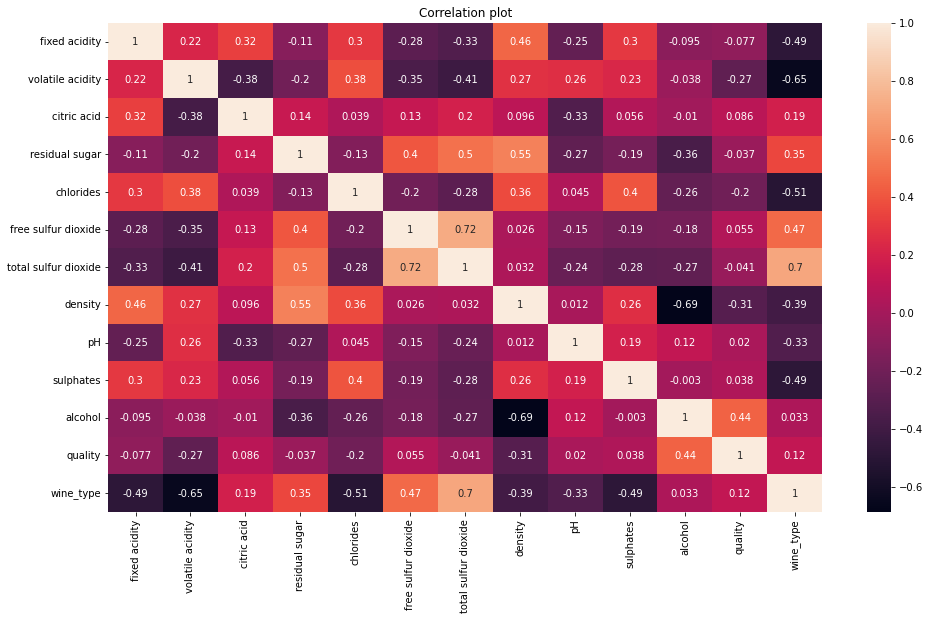

In [9]:
plt.figure(figsize = (16,9))
cor = data.corr()
sns.heatmap(cor, annot = True); plt.title('Correlation plot');

In [10]:
pair_corr = pd.DataFrame(cor.unstack(), columns = ['cor'])

In [11]:
pair_corr[((pair_corr['cor'] > -0.6) | (pair_corr['cor'] > 0.6)) & pair_corr['cor'] != 1]

,,cor
volatile acidity,wine_type,-0.653036
density,alcohol,-0.686745
alcohol,density,-0.686745
wine_type,volatile acidity,-0.653036


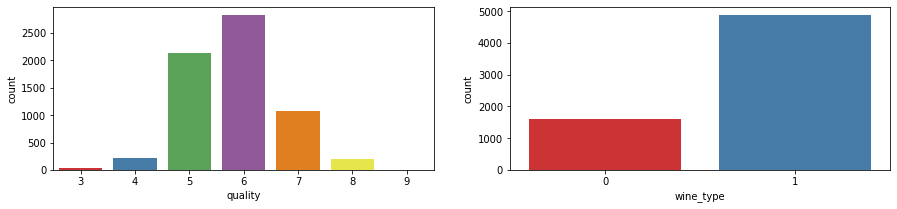

In [12]:
fig, ax = plt.subplots(1,2, figsize = (15,3))
sns.countplot(x = 'quality', data = data, palette = 'Set1', ax = ax[0])
sns.countplot(x = 'wine_type', data = data, palette = 'Set1', ax = ax[1]);

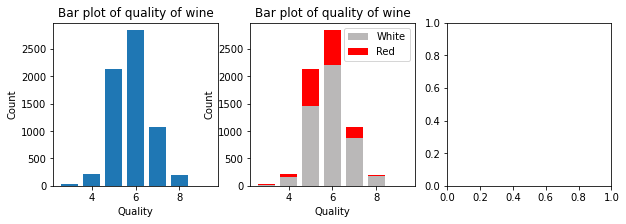

In [13]:
fig, ax = plt.subplots(1,3, figsize = (10,3))
ax[0].bar(data.quality.value_counts().index, data.quality.value_counts())
ax[0].set_title('Bar plot of quality of wine')
ax[0].set_xlabel('Quality'); ax[0].set_ylabel('Count');
df1 = pd.crosstab(data.quality, data.wine_type)
ax[1].bar(df1.index, df1[1], color = '#bab8b8')
ax[1].bar(df1.index, df1[0], bottom = df1[1], color = 'r')
ax[1].legend(['White','Red'])
ax[1].set_title('Bar plot of quality of wine')
ax[1].set_xlabel('Quality'); ax[1].set_ylabel('Count');

As pytorch supports label starting from 0, then we need to map the class label from 3:8 to 0:6 respectively.

In [14]:
# encode output class
class2idx = {i:j for (i,j) in zip([3,4,5,6,7,8,9],[0,1,2,3,4,5,6])}
data.quality.replace(class2idx, inplace = True)

In [15]:
# create input and output data
y = data.quality
X = data.drop(['quality'], axis = 1)

From the above bar chart clearly classes are imbalance. So, to make equally distributed classes stratified sampling can be done.

First test set is separated and then train and validation dataset is splitted from train_val data. Splitting percentage: 80-10-20 (train, validation, test)

In [16]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size = 0.20, shuffle=True, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.10, shuffle = True, stratify=y_train_val)

In [17]:
print('Shape of train dataset: {} and target data: {}'.format(X_train.shape, y_train.shape))
print('Shape of validation dataset: {} and target data: {}'.format(X_val.shape, y_val.shape))
print('Shape of test dataset: {} and target data: {}'.format(X_test.shape, y_test.shape))

Shape of train dataset: (4677, 12) and target data: (4677,)
Shape of validation dataset: (520, 12) and target data: (520,)
Shape of test dataset: (1300, 12) and target data: (1300,)


Data normalization is very much needed to scale down to make unit free value for each feature.

In [18]:
normalizer = preprocessing.Normalizer()
X_train = normalizer.fit_transform(X_train)
X_val = normalizer.transform(X_val)
X_test = normalizer.transform(X_test)

Convert everything to array.

In [19]:
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

Class distribution for train, validation and test dataset.

In [20]:
def class_distribution(arr):
    label, count = np.unique(arr, return_counts=True)
    return {i:j for (i,j) in zip(label, count/count.sum())}

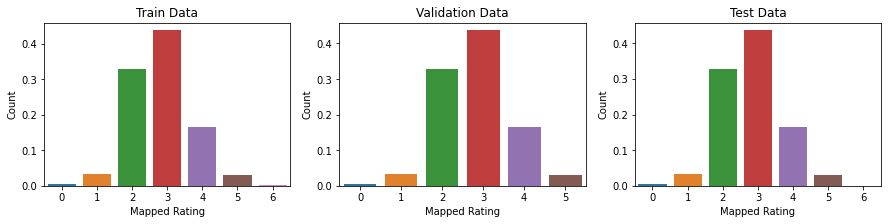

In [21]:
f, ax = plt.subplots(1,3, figsize = (15,3))
ax1 = sns.barplot(x = 'variable', y = 'value', data = pd.DataFrame.from_dict([class_distribution(y_train)]).melt(), ax = ax[0])
ax1.set(xlabel = 'Mapped Rating', ylabel = 'Count', title = 'Train Data')
ax2 = sns.barplot(x = 'variable', y = 'value', data = pd.DataFrame.from_dict([class_distribution(y_val)]).melt(), ax = ax[1])
ax2.set(xlabel = 'Mapped Rating', ylabel = 'Count', title = 'Validation Data')
ax3 = sns.barplot(x = 'variable', y = 'value', data = pd.DataFrame.from_dict([class_distribution(y_test)]).melt(), ax = ax[2])
ax3.set(xlabel = 'Mapped Rating', ylabel = 'Count', title = 'Test Data');

Defining custom dataset class that will be used by dataloader for passing the data into model.

In [22]:
# step-1: initialize, step-2: getting item, step-3: length of data
class WineData(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
    def __len__(self):
        return len(self.X)

In [23]:
# making dataset, after this step dataset are ready to put into the dataloader
train_dataset = WineData(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
val_dataset = WineData(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
test_dataset = WineData(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

In [24]:
target_list = []
for _, target in train_dataset:
    target_list.append(target)
    
target_list = torch.tensor(target_list)

In [25]:
label, count = np.unique(y_train, return_counts=True)
class_weights = 1/torch.tensor(count)

In [26]:
# as classes are already encoded from 0 to 6
class_weights_all = class_weights[target_list]

In [27]:
# initialize WeightedRandomSampler
weighted_sampler = WeightedRandomSampler(
    weights = class_weights_all,
    num_samples = len(class_weights_all),
    replacement = True
)

In [28]:
# define model parameters
EPOCHS = 100
BATCH_SIZE = X_train.shape[0]
LEARNING_RATE = 5e-3
N_FEATURE = len(X.columns)
N_CLASS = 7

In [29]:
# shuffle and sampler are mutually exclusive
train_loader = DataLoader(dataset = train_dataset, 
                          batch_size = BATCH_SIZE, 
                          sampler = weighted_sampler)
val_loader = DataLoader(dataset = val_dataset, batch_size = X_val.shape[0])
test_loader = DataLoader(dataset = test_dataset, batch_size = X_test.shape[0])

Define Neural Network Architecture

In [30]:
# define neural net architecture: inheritate the nn.Module into the self made class 
# object and the define the forward pass
class MCCLF(nn.Module):
    def __init__(self, n_feature, n_class):
        super(MCCLF, self).__init__()
        
        self.input_layer = nn.Linear(n_feature, 32)
        self.hidden_layer_1 = nn.Linear(32, 64)
        self.hidden_layer_2 = nn.Linear(64, 16)
        self.output_layer = nn.Linear(16, n_class)
        
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x =  self.input_layer(x)
        x = self.relu(x)
        
        x = self.hidden_layer_1(x)
        
        x = self.hidden_layer_2(x)
        x = self.relu(x)
        
        x = self.output_layer(x)
        return x

In [31]:
# device = 'cuda' if torch.cuda.is_available else 'cpu'
# print(device)
device = "cpu"

In [32]:
# define model
model = MCCLF(n_feature=N_FEATURE, n_class=N_CLASS)

In [33]:
# model to device
model.to(device)

MCCLF(
  (input_layer): Linear(in_features=12, out_features=32, bias=True)
  (hidden_layer_1): Linear(in_features=32, out_features=64, bias=True)
  (hidden_layer_2): Linear(in_features=64, out_features=16, bias=True)
  (output_layer): Linear(in_features=16, out_features=7, bias=True)
  (relu): ReLU()
)

In [34]:
# define loss funtion and also send the weights to the device
loss_fn = nn.CrossEntropyLoss(weight=class_weights.to(device))

In [35]:
# define optimizer (SGD)
optimizer = optim.SGD(model.parameters(), lr = LEARNING_RATE)

In [36]:
# define accuracy function
def accuracy(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_label = torch.max(y_pred_softmax, dim = 1)
    correct_pred = (y_pred_label == y_test).float()
    acc = correct_pred.sum()*100/len(correct_pred)
    return acc

In [37]:
# dictionary to store the informations per epoch
loss_stat = {'train':[], 'val':[]}
accuracy_stat = {'train':[], 'val':[]}

In [38]:
print('Training start, Please wait.....'); start = time.time()
# part-1: training # part-2: validation
# initialize lists to store traininng loss and accuracy
# initialize lists to store gradients and norm of the gradient (of loss function)
# train the model
# for a batch: send to device, initialize gradient in optimizer

for epoch in tqdm(range(1, EPOCHS+1)):
    train_epoch_loss = []
    train_epoch_acc = []
    loss_grad = []
    norm_loss_grad = []
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        
        train_loss = loss_fn(y_train_pred, y_train_batch)
        train_acc = accuracy(y_train_pred, y_train_batch)
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss.append(train_loss.item())
        train_epoch_acc.append(train_acc.item())
    
    with torch.no_grad():
        val_epoch_loss = []
        val_epoch_acc = []
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
            
            val_loss = loss_fn(y_val_pred, y_val_batch)
            val_acc = accuracy(y_val_pred, y_val_batch)
            
            val_epoch_loss.append(val_loss.item())
            val_epoch_acc.append(val_acc.item())
            
        loss_stat['train'].append(np.round(np.sum(train_epoch_loss)/len(train_loader), 5))
        loss_stat['val'].append(np.round(np.sum(val_epoch_loss)/len(val_loader), 5))
        accuracy_stat['train'].append(np.round(np.sum(train_epoch_acc)/len(train_loader), 5))
        accuracy_stat['val'].append(np.round(np.sum(val_epoch_acc)/len(val_loader), 5))

        print('Epoch {:03}: Train loss: {:.5f} | Validation Loss: {:.5f} | Train accuracy: {:.4f} | Validation accuracy: {:.4f}'.format(
        epoch,
        np.sum(train_epoch_loss)/len(train_loader),
        np.sum(val_epoch_loss)/len(val_loader),
        np.sum(train_epoch_acc)/len(train_loader),
        np.sum(val_epoch_acc)/len(val_loader)))        

print('Yeah Finished! Total time taken: {:.2f} seconds.'.format(time.time()-start))

Training start, Please wait.....


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 001: Train loss: 2.07101 | Validation Loss: 1.92690 | Train accuracy: 13.8978 | Validation accuracy: 3.0769
Epoch 002: Train loss: 2.06172 | Validation Loss: 1.92758 | Train accuracy: 14.4965 | Validation accuracy: 3.0769
Epoch 003: Train loss: 2.06602 | Validation Loss: 1.92829 | Train accuracy: 13.7054 | Validation accuracy: 3.0769
Epoch 004: Train loss: 2.05717 | Validation Loss: 1.92901 | Train accuracy: 13.5129 | Validation accuracy: 3.0769
Epoch 005: Train loss: 2.05365 | Validation Loss: 1.92975 | Train accuracy: 14.3254 | Validation accuracy: 3.0769
Epoch 006: Train loss: 2.04800 | Validation Loss: 1.93049 | Train accuracy: 14.2613 | Validation accuracy: 3.0769
Epoch 007: Train loss: 2.03930 | Validation Loss: 1.93121 | Train accuracy: 14.2185 | Validation accuracy: 3.0769
Epoch 008: Train loss: 2.03808 | Validation Loss: 1.93195 | Train accuracy: 15.2021 | Validation accuracy: 3.0769
Epoch 009: Train loss: 2.03659 | Validation Loss: 1.93271 | Train accuracy: 13.9619 | Va